# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate synthetic data

100%|██████████| 2000/2000 [00:48<00:00, 41.13it/s]


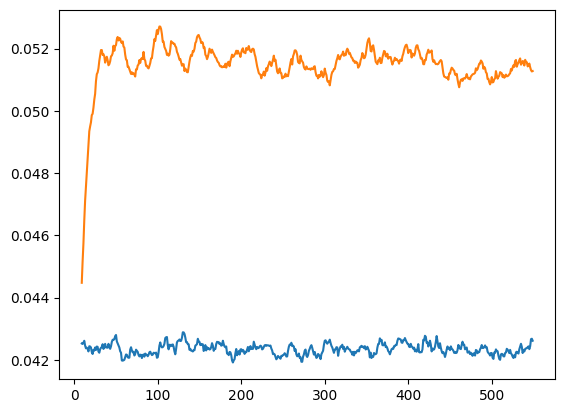

In [226]:
from VAETransformer_FCGPFA import get_K
### Generate data
torch.manual_seed(0)
np.random.seed(0)

MAX_FIRING_RATE = 10
gt_neuron_params = {'baseline_fr':0.03, 'ntrial':2000, 'narea':2, 'nneuron_area':50, 
                    'nt':500, 'npadding':50}
gt_latent_params = {'sigma2':1, 'nlatent':2, 'offset':0.0, 'L':250}
coupling_filter_params = {'peaks_max':10, 'num':3, 'nonlinear':0.5}
nfactor_baseline = gt_latent_params['nlatent']
connections = [{'send':0, 'receive':1, 
                'strength': np.array([[1,0.25],[0,0.5],[0,0.25]])/10,
                'nneuron_involved': 10}]

ntrial = gt_neuron_params['ntrial']
nneuron = gt_neuron_params['narea']*gt_neuron_params['nneuron_area']
nneuron_area = gt_neuron_params['nneuron_area']
narea = gt_neuron_params['narea']
basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
max_histories, nbasis = basis_coupling.shape
nt = gt_neuron_params['nt'] + gt_neuron_params['npadding']
nfactor_coupling_tot = sum([conn['strength'].shape[1] for conn in connections])

baseline_mat = np.ones((nt, nneuron, ntrial))*np.log(gt_neuron_params['baseline_fr'])
spikes = np.zeros((nt, nneuron, ntrial))
log_firing_rate_rcd = np.zeros((nt, nneuron, ntrial))

# Prepare loading_mat_baseline
loading_mat_baseline_list = [np.zeros((nneuron_area, nfactor_baseline)) for _ in range(narea)]
for jarea in range(narea):
    loading_mat_baseline_list[jarea] = (
        np.random.uniform(low=-1, high=1, size=(nneuron_area, nfactor_baseline))
    )

# Prepare baseline_mat
for jarea in range(narea):
    K_gt = get_K(nt=nt, L=gt_latent_params['L'], sigma2=gt_latent_params['sigma2'])
    factor_baseline = np.random.multivariate_normal(
        np.zeros(nt), K_gt, (ntrial, nfactor_baseline)
    ).transpose(2, 1, 0) # nt x nlatent x ntrial
    baseline_mat[:, jarea*nneuron_area:(jarea+1)*nneuron_area, :] += (
        np.einsum('nf, tfm -> tnm', loading_mat_baseline_list[jarea], factor_baseline)
    )

# Prepare coupling_mat
readin_mat_coupling = np.zeros((nneuron, nfactor_coupling_tot))
coupling_mat = np.zeros((max_histories, nneuron, nfactor_coupling_tot))
loading_mat_coupling = np.zeros((nneuron, nfactor_coupling_tot))
nfactor_coupling_counter = 0
for i, connection in enumerate(connections):
    nneuron_involved = connection['nneuron_involved']
    nfactor_coupling = connection['strength'].shape[1]
    readin_mat_coupling[
        connection['send']*nneuron_area:connection['send']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = np.random.uniform(low=0.8, high=1.2, size=(nneuron_involved, nfactor_coupling))
    coupling_mat[
        :, 
        connection['send']*nneuron_area:connection['send']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = (basis_coupling @ connection['strength'])[::-1, np.newaxis, :]
    coupling_mat *= readin_mat_coupling[np.newaxis, :, :]
    loading_mat_coupling[
        connection['receive']*nneuron_area:connection['receive']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = np.random.uniform(low=0.8, high=1.2, size=(nneuron_involved, nfactor_coupling))
    nfactor_coupling_counter += nfactor_coupling

# Generate spikes
for itrial in tqdm(range(ntrial)):
    spikes_single_trial = np.zeros((nt, nneuron, 1))
    log_firing_rate = copy.copy(baseline_mat[:,:,itrial:itrial+1])
    spikes_single_trial[0,:,0] = np.random.poisson(np.exp(log_firing_rate[0,:, 0]))

    for t in range(1, nt):
        nhistories = min(t, max_histories)
        factor_coupling = (coupling_mat[-nhistories:, :, :] \
                * spikes_single_trial[(t-nhistories):(t), :, :]).sum(axis=(0, 1))
        log_firing_rate[t,:,0] += (loading_mat_coupling @ factor_coupling[:, np.newaxis]).squeeze()
        log_firing_rate[t,:,0] = np.minimum(log_firing_rate[t,:,0], MAX_FIRING_RATE)
        spikes_single_trial[t,:,0] = np.random.poisson(np.exp(log_firing_rate[t,:,0]))
        # spikes_single_trial[t,:,0] = np.exp(log_firing_rate[t,:,0])

    log_firing_rate = log_firing_rate.squeeze()
    spikes_single_trial = spikes_single_trial.squeeze()
    spikes[:, :, itrial] = spikes_single_trial
    log_firing_rate_rcd[:, :, itrial] = log_firing_rate


spikes_area = [spikes[:,iarea*nneuron_area:(iarea+1)*nneuron_area,:] for iarea in range(narea)]

window_size = 10
for i in range(narea):
    smoothed_spikes = pd.Series(spikes_area[i].mean(axis=(1,2))).rolling(window=window_size).mean()
    plt.plot(smoothed_spikes)
plt.show()


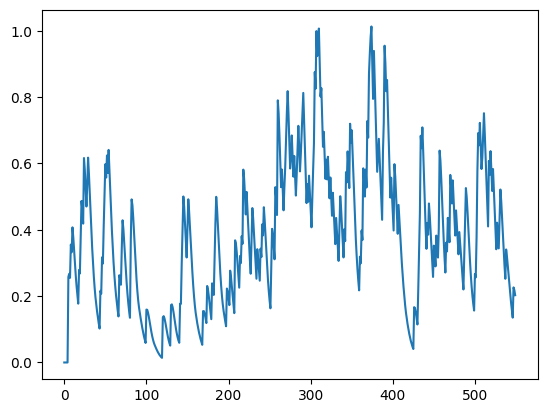

In [227]:
coupling_effect = log_firing_rate_rcd - baseline_mat
plt.plot(coupling_effect[:,55,0])

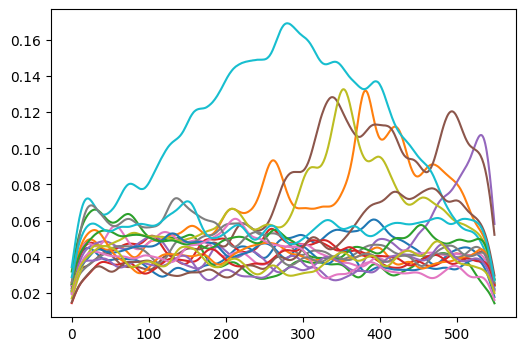

In [228]:
plt.figure(figsize=(6,4))
# Define Gaussian kernel for smoothing
kernel_width = 10
kernel = np.exp(-np.arange(-3*kernel_width, 3*kernel_width+1)**2 / (2*kernel_width**2))
kernel = kernel / kernel.sum()  # Normalize

for trial in range(20):  # Plot first 20 trials
    # Get mean across neurons for this trial
    trial_mean = spikes[:,:,trial].mean(axis=1)
    # Apply kernel smoothing via convolution
    smoothed = np.convolve(trial_mean, kernel, mode='same')
    plt.plot(smoothed)


Text(0.5, 1.0, 'Spike raster for neuron 55')

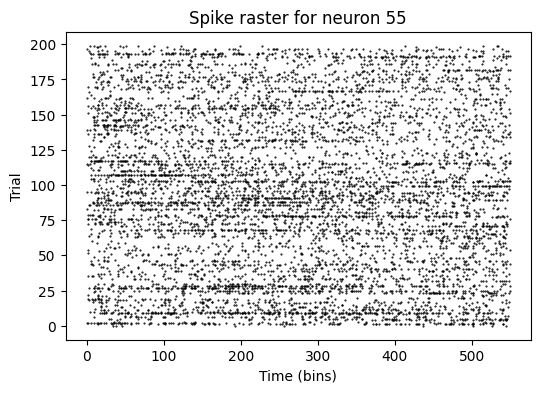

In [229]:
# Plot raster for one example neuron
neuron_idx = 55  # Choose first neuron
plt.figure(figsize=(6,4))
for trial in range(200):  # Plot first 200 trials
    spike_times = np.where(spikes[:,neuron_idx,trial])[0]
    plt.plot(spike_times, trial*np.ones_like(spike_times), '.', markersize=1, color='black')
plt.xlabel('Time (bins)')
plt.ylabel('Trial')
plt.title(f'Spike raster for neuron {neuron_idx}')


In [230]:
nneuron = spikes.shape[1]//2

synthetic_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron,:], spikes[:,nneuron:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

# Train a model

Current problems:
- Not stable! Run the code multiple times, the results are different. **Solved by temporal correlation penalty**
- The coupling effect is not capturing what it should capture. ** **

Things I want to try:
- see if the baseline looks good. **YES**
- I want to get a clear two modes in t-sne plot, since the ground truth is two modes. **YES**
- Play with hyperparameters, see what appect the results. **lr is still very important. Epoch is also important.**
- Try make coupling effect weaker by setting initial value to be around zero. I don't want to see the coupling effect being too strong. **can be done by frozing Transformer encoder**
- See how would overlapping penalty affect the results. overlapping_penalty=None: 0.2283
overlapping_penalty=1e0: 0.2289. **but overlapping penalty makes coupling very small**
- Try penalty temporal correlation. **Works great!**
- Try not frozing Transformer encoder. **(a different dataset than the previous one) 0.2300 vs 0.2308. So Yes, frozing encoder**
- Try cls token. **No, will lead to mode collapse**
- Get a set of hyperparameters that works in both conn=0.0 and conn=0.01. ** **
- compare with no f(z,t) but just f(t). The coupling effect should be much stronger. 


- I don't know why the first element in both sending and receiving weights are much larger than the rest.


In [231]:
FIT_THE_BASELINE_MODEL = False

# data_to_use = cross_session_dataloader
data_to_use = synthetic_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

params = {
    # B-spline basis
    'num_B_spline_basis': 10,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 4,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 1,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    # Coupling's settings
    'coupling_basis_peaks_max': 10,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 2,
    'use_self_coupling': False,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_overlapping': None, 
    'penalty_coupling_subset': 1e-5,
    'penalty_weight_dissimilarity': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    'weight_decay': 1e-5,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)

if FIT_THE_BASELINE_MODEL:
    # Baseline model: no trial-varying stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )

else:
    # First step: train the model with a trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )
    # Second step: train the model with a trial-varying stimulus effect
    # trainer.make_optimizer(frozen_params=['sti_readout'])
    trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )

    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )



/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 4, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 2, 'use_self_coupling': False, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'penalty_coupling_subset': 1e-05, 'penalty_weight_dissimilarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 1e-05, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 190.02it/s]


Epoch 1/200, Train Loss: 1.0145, Test Loss: 0.8405


100%|██████████| 4/4 [00:00<00:00, 187.67it/s]


Epoch 2/200, Train Loss: 0.6914, Test Loss: 0.5390


100%|██████████| 4/4 [00:00<00:00, 190.63it/s]


Epoch 3/200, Train Loss: 0.4350, Test Loss: 0.3411


100%|██████████| 4/4 [00:00<00:00, 190.08it/s]


Epoch 4/200, Train Loss: 0.2914, Test Loss: 0.2503


100%|██████████| 4/4 [00:00<00:00, 189.46it/s]


Epoch 5/200, Train Loss: 0.2318, Test Loss: 0.2160


100%|██████████| 4/4 [00:00<00:00, 187.70it/s]


Epoch 6/200, Train Loss: 0.2090, Test Loss: 0.2022


100%|██████████| 4/4 [00:00<00:00, 180.84it/s]


Epoch 7/200, Train Loss: 0.1994, Test Loss: 0.1959


100%|██████████| 4/4 [00:00<00:00, 189.66it/s]


Epoch 8/200, Train Loss: 0.1946, Test Loss: 0.1926


100%|██████████| 4/4 [00:00<00:00, 137.77it/s]


Epoch 9/200, Train Loss: 0.1921, Test Loss: 0.1907


100%|██████████| 4/4 [00:00<00:00, 115.69it/s]


Epoch 10/200, Train Loss: 0.1906, Test Loss: 0.1896


100%|██████████| 4/4 [00:00<00:00, 185.35it/s]


Epoch 11/200, Train Loss: 0.1897, Test Loss: 0.1890


100%|██████████| 4/4 [00:00<00:00, 186.02it/s]


Epoch 12/200, Train Loss: 0.1892, Test Loss: 0.1885


100%|██████████| 4/4 [00:00<00:00, 188.26it/s]


Epoch 13/200, Train Loss: 0.1888, Test Loss: 0.1882


100%|██████████| 4/4 [00:00<00:00, 125.98it/s]


Epoch 14/200, Train Loss: 0.1886, Test Loss: 0.1880


100%|██████████| 4/4 [00:00<00:00, 181.28it/s]


Epoch 15/200, Train Loss: 0.1884, Test Loss: 0.1879


100%|██████████| 4/4 [00:00<00:00, 184.37it/s]


Epoch 16/200, Train Loss: 0.1883, Test Loss: 0.1878


100%|██████████| 4/4 [00:00<00:00, 178.04it/s]


Epoch 17/200, Train Loss: 0.1883, Test Loss: 0.1877


100%|██████████| 4/4 [00:00<00:00, 96.43it/s]


Epoch 18/200, Train Loss: 0.1882, Test Loss: 0.1877


100%|██████████| 4/4 [00:00<00:00, 191.24it/s]


Epoch 19/200, Train Loss: 0.1882, Test Loss: 0.1877


100%|██████████| 4/4 [00:00<00:00, 189.38it/s]


Epoch 20/200, Train Loss: 0.1881, Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 171.71it/s]


Epoch 21/200, Train Loss: 0.1881, Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 175.21it/s]


Epoch 22/200, Train Loss: 0.1881, Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 190.27it/s]


Epoch 23/200, Train Loss: 0.1881, Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 91.19it/s]


Epoch 24/200, Train Loss: 0.1881, Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 185.63it/s]


Epoch 25/200, Train Loss: 0.1880, Test Loss: 0.1876
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 188.73it/s]


Epoch 26/200, Train Loss: 0.1880, Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 188.42it/s]


Epoch 27/200, Train Loss: 0.1880, Test Loss: 0.1876
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 190.20it/s]


Epoch 28/200, Train Loss: 0.1880, Test Loss: 0.1876
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 191.25it/s]


Epoch 29/200, Train Loss: 0.1880, Test Loss: 0.1875


100%|██████████| 4/4 [00:00<00:00, 190.78it/s]


Epoch 30/200, Train Loss: 0.1880, Test Loss: 0.1875
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1875


100%|██████████| 4/4 [00:00<00:00, 111.90it/s]


Epoch 31/200, Train Loss: 0.1880, Test Loss: 0.1875
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1875


100%|██████████| 4/4 [00:00<00:00, 79.26it/s]
/home/qix/FC-GPFA/model_trainer.py:285: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  


Epoch 32/200, Train Loss: 0.1880, Test Loss: 0.1875
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.1875
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 4, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 2, 'use_self_coupling': False, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'penalty_coupling_subset': 1e-05, 'penalty_weight_dissimilarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 1e-05, 'lr_transformer': 0.0001, 'lr_sti': 0.01, '

100%|██████████| 4/4 [00:00<00:00, 111.18it/s]


Epoch 1/200, Train Loss: 0.1919, Test Loss: 0.1876


100%|██████████| 4/4 [00:00<00:00, 80.81it/s]


Epoch 2/200, Train Loss: 0.1878, Test Loss: 0.1869


100%|██████████| 4/4 [00:00<00:00, 92.06it/s]


Epoch 3/200, Train Loss: 0.1874, Test Loss: 0.1865


100%|██████████| 4/4 [00:00<00:00, 76.31it/s]


Epoch 4/200, Train Loss: 0.1870, Test Loss: 0.1861


100%|██████████| 4/4 [00:00<00:00, 111.11it/s]


Epoch 5/200, Train Loss: 0.1867, Test Loss: 0.1860


100%|██████████| 4/4 [00:00<00:00, 128.70it/s]


Epoch 6/200, Train Loss: 0.1866, Test Loss: 0.1859


100%|██████████| 4/4 [00:00<00:00, 164.67it/s]


Epoch 7/200, Train Loss: 0.1865, Test Loss: 0.1858


100%|██████████| 4/4 [00:00<00:00, 160.04it/s]


Epoch 8/200, Train Loss: 0.1864, Test Loss: 0.1857


100%|██████████| 4/4 [00:00<00:00, 148.79it/s]


Epoch 9/200, Train Loss: 0.1863, Test Loss: 0.1856


100%|██████████| 4/4 [00:00<00:00, 164.77it/s]


Epoch 10/200, Train Loss: 0.1861, Test Loss: 0.1854


100%|██████████| 4/4 [00:00<00:00, 164.05it/s]


Epoch 11/200, Train Loss: 0.1859, Test Loss: 0.1851


100%|██████████| 4/4 [00:00<00:00, 117.53it/s]


Epoch 12/200, Train Loss: 0.1856, Test Loss: 0.1849


100%|██████████| 4/4 [00:00<00:00, 166.57it/s]


Epoch 13/200, Train Loss: 0.1854, Test Loss: 0.1848


100%|██████████| 4/4 [00:00<00:00, 170.10it/s]


Epoch 14/200, Train Loss: 0.1853, Test Loss: 0.1846


100%|██████████| 4/4 [00:00<00:00, 166.07it/s]


Epoch 15/200, Train Loss: 0.1851, Test Loss: 0.1844


100%|██████████| 4/4 [00:00<00:00, 163.93it/s]


Epoch 16/200, Train Loss: 0.1850, Test Loss: 0.1843


100%|██████████| 4/4 [00:00<00:00, 168.79it/s]


Epoch 17/200, Train Loss: 0.1848, Test Loss: 0.1842


100%|██████████| 4/4 [00:00<00:00, 171.10it/s]


Epoch 18/200, Train Loss: 0.1847, Test Loss: 0.1840


100%|██████████| 4/4 [00:00<00:00, 123.25it/s]


Epoch 19/200, Train Loss: 0.1845, Test Loss: 0.1839


100%|██████████| 4/4 [00:00<00:00, 119.91it/s]


Epoch 20/200, Train Loss: 0.1843, Test Loss: 0.1837


100%|██████████| 4/4 [00:00<00:00, 160.83it/s]


Epoch 21/200, Train Loss: 0.1841, Test Loss: 0.1834


100%|██████████| 4/4 [00:00<00:00, 78.12it/s]


Epoch 22/200, Train Loss: 0.1838, Test Loss: 0.1832


100%|██████████| 4/4 [00:00<00:00, 167.27it/s]


Epoch 23/200, Train Loss: 0.1836, Test Loss: 0.1831


100%|██████████| 4/4 [00:00<00:00, 94.60it/s]


Epoch 24/200, Train Loss: 0.1835, Test Loss: 0.1829


100%|██████████| 4/4 [00:00<00:00, 119.41it/s]


Epoch 25/200, Train Loss: 0.1833, Test Loss: 0.1828


100%|██████████| 4/4 [00:00<00:00, 158.81it/s]


Epoch 26/200, Train Loss: 0.1832, Test Loss: 0.1826


100%|██████████| 4/4 [00:00<00:00, 164.77it/s]


Epoch 27/200, Train Loss: 0.1830, Test Loss: 0.1825


100%|██████████| 4/4 [00:00<00:00, 116.94it/s]


Epoch 28/200, Train Loss: 0.1828, Test Loss: 0.1823


100%|██████████| 4/4 [00:00<00:00, 168.19it/s]


Epoch 29/200, Train Loss: 0.1827, Test Loss: 0.1822


100%|██████████| 4/4 [00:00<00:00, 167.69it/s]


Epoch 30/200, Train Loss: 0.1825, Test Loss: 0.1820


100%|██████████| 4/4 [00:00<00:00, 168.40it/s]


Epoch 31/200, Train Loss: 0.1824, Test Loss: 0.1819


100%|██████████| 4/4 [00:00<00:00, 166.48it/s]


Epoch 32/200, Train Loss: 0.1823, Test Loss: 0.1817


100%|██████████| 4/4 [00:00<00:00, 167.13it/s]


Epoch 33/200, Train Loss: 0.1821, Test Loss: 0.1816


100%|██████████| 4/4 [00:00<00:00, 111.66it/s]


Epoch 34/200, Train Loss: 0.1820, Test Loss: 0.1815


100%|██████████| 4/4 [00:00<00:00, 169.84it/s]


Epoch 35/200, Train Loss: 0.1819, Test Loss: 0.1814


100%|██████████| 4/4 [00:00<00:00, 96.67it/s]


Epoch 36/200, Train Loss: 0.1818, Test Loss: 0.1812


100%|██████████| 4/4 [00:00<00:00, 166.00it/s]


Epoch 37/200, Train Loss: 0.1816, Test Loss: 0.1811


100%|██████████| 4/4 [00:00<00:00, 163.22it/s]


Epoch 38/200, Train Loss: 0.1815, Test Loss: 0.1811


100%|██████████| 4/4 [00:00<00:00, 147.28it/s]


Epoch 39/200, Train Loss: 0.1814, Test Loss: 0.1810


100%|██████████| 4/4 [00:00<00:00, 93.41it/s]


Epoch 40/200, Train Loss: 0.1814, Test Loss: 0.1809


100%|██████████| 4/4 [00:00<00:00, 154.41it/s]


Epoch 41/200, Train Loss: 0.1813, Test Loss: 0.1808


100%|██████████| 4/4 [00:00<00:00, 104.19it/s]


Epoch 42/200, Train Loss: 0.1812, Test Loss: 0.1807


100%|██████████| 4/4 [00:00<00:00, 169.77it/s]


Epoch 43/200, Train Loss: 0.1811, Test Loss: 0.1805


100%|██████████| 4/4 [00:00<00:00, 89.09it/s]


Epoch 44/200, Train Loss: 0.1810, Test Loss: 0.1805


100%|██████████| 4/4 [00:00<00:00, 162.41it/s]


Epoch 45/200, Train Loss: 0.1809, Test Loss: 0.1804


100%|██████████| 4/4 [00:00<00:00, 99.76it/s]


Epoch 46/200, Train Loss: 0.1808, Test Loss: 0.1803


100%|██████████| 4/4 [00:00<00:00, 160.48it/s]


Epoch 47/200, Train Loss: 0.1807, Test Loss: 0.1802


100%|██████████| 4/4 [00:00<00:00, 147.42it/s]


Epoch 48/200, Train Loss: 0.1806, Test Loss: 0.1801


100%|██████████| 4/4 [00:00<00:00, 147.22it/s]


Epoch 49/200, Train Loss: 0.1805, Test Loss: 0.1800


100%|██████████| 4/4 [00:00<00:00, 110.19it/s]


Epoch 50/200, Train Loss: 0.1804, Test Loss: 0.1800


100%|██████████| 4/4 [00:00<00:00, 115.26it/s]


Epoch 51/200, Train Loss: 0.1804, Test Loss: 0.1799


100%|██████████| 4/4 [00:00<00:00, 168.04it/s]


Epoch 52/200, Train Loss: 0.1803, Test Loss: 0.1798


100%|██████████| 4/4 [00:00<00:00, 166.70it/s]


Epoch 53/200, Train Loss: 0.1802, Test Loss: 0.1798


100%|██████████| 4/4 [00:00<00:00, 98.09it/s]


Epoch 54/200, Train Loss: 0.1802, Test Loss: 0.1797


100%|██████████| 4/4 [00:00<00:00, 86.24it/s]


Epoch 55/200, Train Loss: 0.1801, Test Loss: 0.1797


100%|██████████| 4/4 [00:00<00:00, 107.14it/s]


Epoch 56/200, Train Loss: 0.1801, Test Loss: 0.1796


100%|██████████| 4/4 [00:00<00:00, 118.61it/s]


Epoch 57/200, Train Loss: 0.1800, Test Loss: 0.1796


100%|██████████| 4/4 [00:00<00:00, 126.12it/s]


Epoch 58/200, Train Loss: 0.1800, Test Loss: 0.1796


100%|██████████| 4/4 [00:00<00:00, 117.06it/s]


Epoch 59/200, Train Loss: 0.1799, Test Loss: 0.1795


100%|██████████| 4/4 [00:00<00:00, 124.23it/s]


Epoch 60/200, Train Loss: 0.1799, Test Loss: 0.1795


100%|██████████| 4/4 [00:00<00:00, 160.54it/s]


Epoch 61/200, Train Loss: 0.1799, Test Loss: 0.1795


100%|██████████| 4/4 [00:00<00:00, 99.53it/s]


Epoch 62/200, Train Loss: 0.1799, Test Loss: 0.1795


100%|██████████| 4/4 [00:00<00:00, 157.89it/s]


Epoch 63/200, Train Loss: 0.1798, Test Loss: 0.1795


100%|██████████| 4/4 [00:00<00:00, 123.93it/s]


Epoch 64/200, Train Loss: 0.1798, Test Loss: 0.1795


100%|██████████| 4/4 [00:00<00:00, 113.38it/s]


Epoch 65/200, Train Loss: 0.1798, Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 115.03it/s]


Epoch 66/200, Train Loss: 0.1798, Test Loss: 0.1794
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 95.93it/s]


Epoch 67/200, Train Loss: 0.1798, Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 74.89it/s]


Epoch 68/200, Train Loss: 0.1798, Test Loss: 0.1794
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 101.03it/s]


Epoch 69/200, Train Loss: 0.1797, Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 166.07it/s]


Epoch 70/200, Train Loss: 0.1797, Test Loss: 0.1794
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 166.44it/s]


Epoch 71/200, Train Loss: 0.1797, Test Loss: 0.1794
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 107.93it/s]


Epoch 72/200, Train Loss: 0.1797, Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 160.36it/s]


Epoch 73/200, Train Loss: 0.1797, Test Loss: 0.1794
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 74.26it/s]


Epoch 74/200, Train Loss: 0.1797, Test Loss: 0.1794
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1794


100%|██████████| 4/4 [00:00<00:00, 168.49it/s]


Epoch 75/200, Train Loss: 0.1797, Test Loss: 0.1794
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.1794
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 10, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 4, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 2, 'use_self_coupling': False, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'penalty_coupling_subset': 1e-05, 'penalty_weight_dissimilarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 1e-05, 'lr_transformer': 0.0001, 'lr_sti': 0.01, '

100%|██████████| 4/4 [00:00<00:00, 71.64it/s]


Epoch 1/200, Train Loss: 0.1796, Test Loss: 0.1791


100%|██████████| 4/4 [00:00<00:00, 149.68it/s]


Epoch 2/200, Train Loss: 0.1792, Test Loss: 0.1787


100%|██████████| 4/4 [00:00<00:00, 142.06it/s]


Epoch 3/200, Train Loss: 0.1789, Test Loss: 0.1786


100%|██████████| 4/4 [00:00<00:00, 96.34it/s]


Epoch 4/200, Train Loss: 0.1788, Test Loss: 0.1785


100%|██████████| 4/4 [00:00<00:00, 77.26it/s]


Epoch 5/200, Train Loss: 0.1787, Test Loss: 0.1785


100%|██████████| 4/4 [00:00<00:00, 141.47it/s]


Epoch 6/200, Train Loss: 0.1787, Test Loss: 0.1784


100%|██████████| 4/4 [00:00<00:00, 147.05it/s]


Epoch 7/200, Train Loss: 0.1786, Test Loss: 0.1784
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1784


100%|██████████| 4/4 [00:00<00:00, 147.26it/s]


Epoch 8/200, Train Loss: 0.1786, Test Loss: 0.1784


100%|██████████| 4/4 [00:00<00:00, 147.03it/s]


Epoch 9/200, Train Loss: 0.1786, Test Loss: 0.1784
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1784


100%|██████████| 4/4 [00:00<00:00, 109.68it/s]


Epoch 10/200, Train Loss: 0.1786, Test Loss: 0.1784


100%|██████████| 4/4 [00:00<00:00, 145.31it/s]


Epoch 11/200, Train Loss: 0.1785, Test Loss: 0.1784
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1784


100%|██████████| 4/4 [00:00<00:00, 143.92it/s]


Epoch 12/200, Train Loss: 0.1785, Test Loss: 0.1783


100%|██████████| 4/4 [00:00<00:00, 145.26it/s]


Epoch 13/200, Train Loss: 0.1785, Test Loss: 0.1783
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1783


100%|██████████| 4/4 [00:00<00:00, 145.20it/s]


Epoch 14/200, Train Loss: 0.1785, Test Loss: 0.1783


100%|██████████| 4/4 [00:00<00:00, 142.30it/s]


Epoch 15/200, Train Loss: 0.1785, Test Loss: 0.1783
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.1783


100%|██████████| 4/4 [00:00<00:00, 115.22it/s]


Epoch 16/200, Train Loss: 0.1785, Test Loss: 0.1783
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.1783


100%|██████████| 4/4 [00:00<00:00, 147.55it/s]

Epoch 17/200, Train Loss: 0.1785, Test Loss: 0.1783
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.1783
Early stopping triggered.


In [232]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

100%|██████████| 7/7 [00:00<00:00, 80.82it/s]

Test loss: 0.1783815137391673
Test loss baseline: 0.18810460539975962


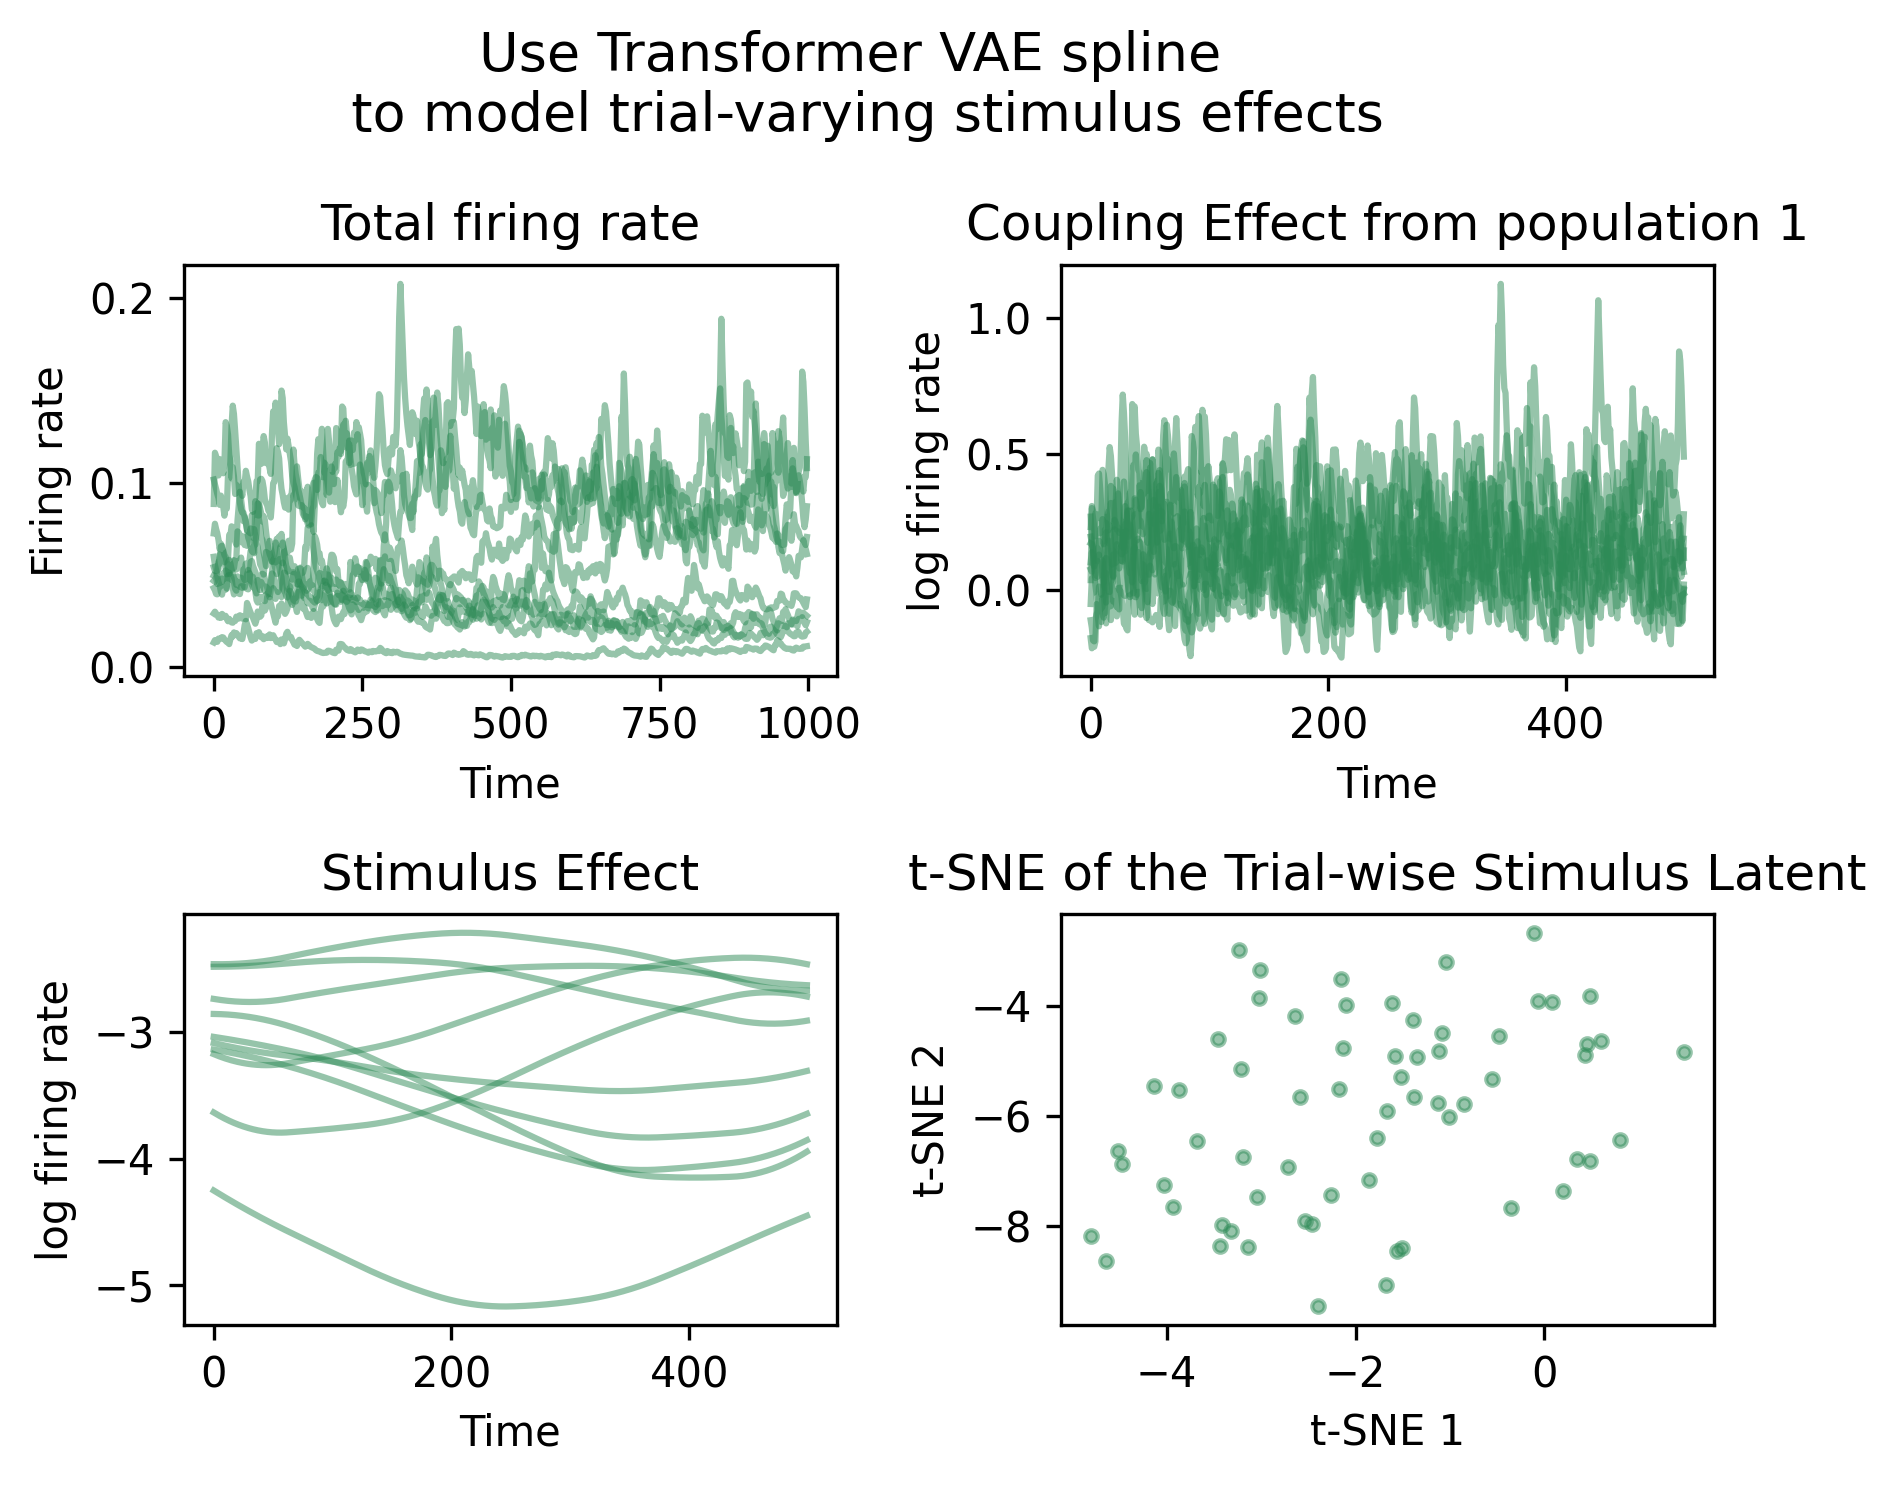

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.manifold import TSNE

local_trial_indices = np.arange(0, 10)
neuron_idx = 55
# plot_trial_info = trial_info["bump"]
# plot_trial_info = trial_info["slope"]
# plot_trial_info = trial_info["gain"]
plot_trial_info = None

# Define colors for min and max values
color_min = '#2E8B57'  # Sea green for minimum value
color_max = '#9370DB'  # Purple for maximum value

firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices = trainer.predict(
    dataset='test',
    batch_indices=[0],
    include_stimulus=True,
    include_coupling=True,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=True,
)

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Use Transformer VAE spline \n to model trial-varying stimulus effects', 
    fontsize=13
)


if plot_trial_info is not None:
    if isinstance(plot_trial_info, np.ndarray) and plot_trial_info.dtype == bool:
        plot_trial_info = plot_trial_info.astype(int)
    plot_trial_info_subset = plot_trial_info[trial_indices[local_trial_indices]]
    info_min, info_max = np.min(plot_trial_info), np.max(plot_trial_info)
    normalized_trial_info = (plot_trial_info[trial_indices] - info_min) / (info_max - info_min)
    cmap = LinearSegmentedColormap.from_list('custom', [color_min, color_max])
    norm = Normalize(vmin=0, vmax=1)

# Plot total firing rate
xx = np.arange(firing_rate_test.shape[0]) * 2  # Adjusted x-axis
for trial_idx in local_trial_indices:
    color = cmap(norm(normalized_trial_info[trial_idx])) if plot_trial_info is not None else color_min
    axes[0, 0].plot(
        xx, 
        np.exp(firing_rate_test[:, neuron_idx, trial_idx].cpu().numpy()), 
        color=color, 
        alpha=0.5
    )
axes[0, 0].set_title('Total firing rate')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Firing rate')

# Add colorbar
if plot_trial_info is not None:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # Create colorbar with custom position [left, bottom, width, height]
    cax = fig.add_axes([1.0, 0.6, 0.02, 0.2])  # Adjust these values as needed
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Overall gain')
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels([f'{info_min:.2f}', f'{info_max:.2f}'])

# Plot coupling effect
for trial_idx in local_trial_indices:
    color = cmap(norm(normalized_trial_info[trial_idx])) if plot_trial_info is not None else color_min
    axes[0, 1].plot(
        trainer.model.coupling_outputs[0][1][trial_idx, neuron_idx-nneuron_area, :].cpu().numpy(),
        color=color,
        alpha=0.5
    )
axes[0, 1].set_title('Coupling Effect from population 1')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('log firing rate')

# Plot stimulus effect
for trial_idx in local_trial_indices:
    color = cmap(norm(normalized_trial_info[trial_idx])) if plot_trial_info is not None else color_min
    axes[1, 0].plot(
        trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy(),
        color=color,
        alpha=0.5
    )
axes[1, 0].set_title('Stimulus Effect')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('log firing rate')

# Plot t-SNE in the last subplot
sti_mu_test_np = sti_mu_test.cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test

if sti_mu_test_np.shape[1] <= 2:
    for i in range(len(sti_mu_test_np)):
        color = cmap(norm(normalized_trial_info[i])) if plot_trial_info is not None else color_min
        axes[1, 1].scatter(
            sti_mu_test_np[i, 0],
            sti_mu_test_np[i, 1],
            alpha=0.5,
            marker='.',
            c=[color]
        )
    axes[1, 1].set_title('Trial-wise Stimulus Latent')
    axes[1, 1].set_xlabel('Latent Dim 1')
    axes[1, 1].set_ylabel('Latent Dim 2')
elif np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    for i in range(len(sti_mu_test_tsne)):
        color = cmap(norm(normalized_trial_info[i])) if plot_trial_info is not None else color_min
        axes[1, 1].scatter(
            sti_mu_test_tsne[i, 0],
            sti_mu_test_tsne[i, 1],
            alpha=0.5,
            marker='.',
            c=[color]
        )
    axes[1, 1].set_title('t-SNE of the Trial-wise Stimulus Latent')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
else:
    print(
        f"Stimulus latent is not varying across trials: "
        f"{sti_mu_test_np.std(axis=0).mean()}"
    )

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)


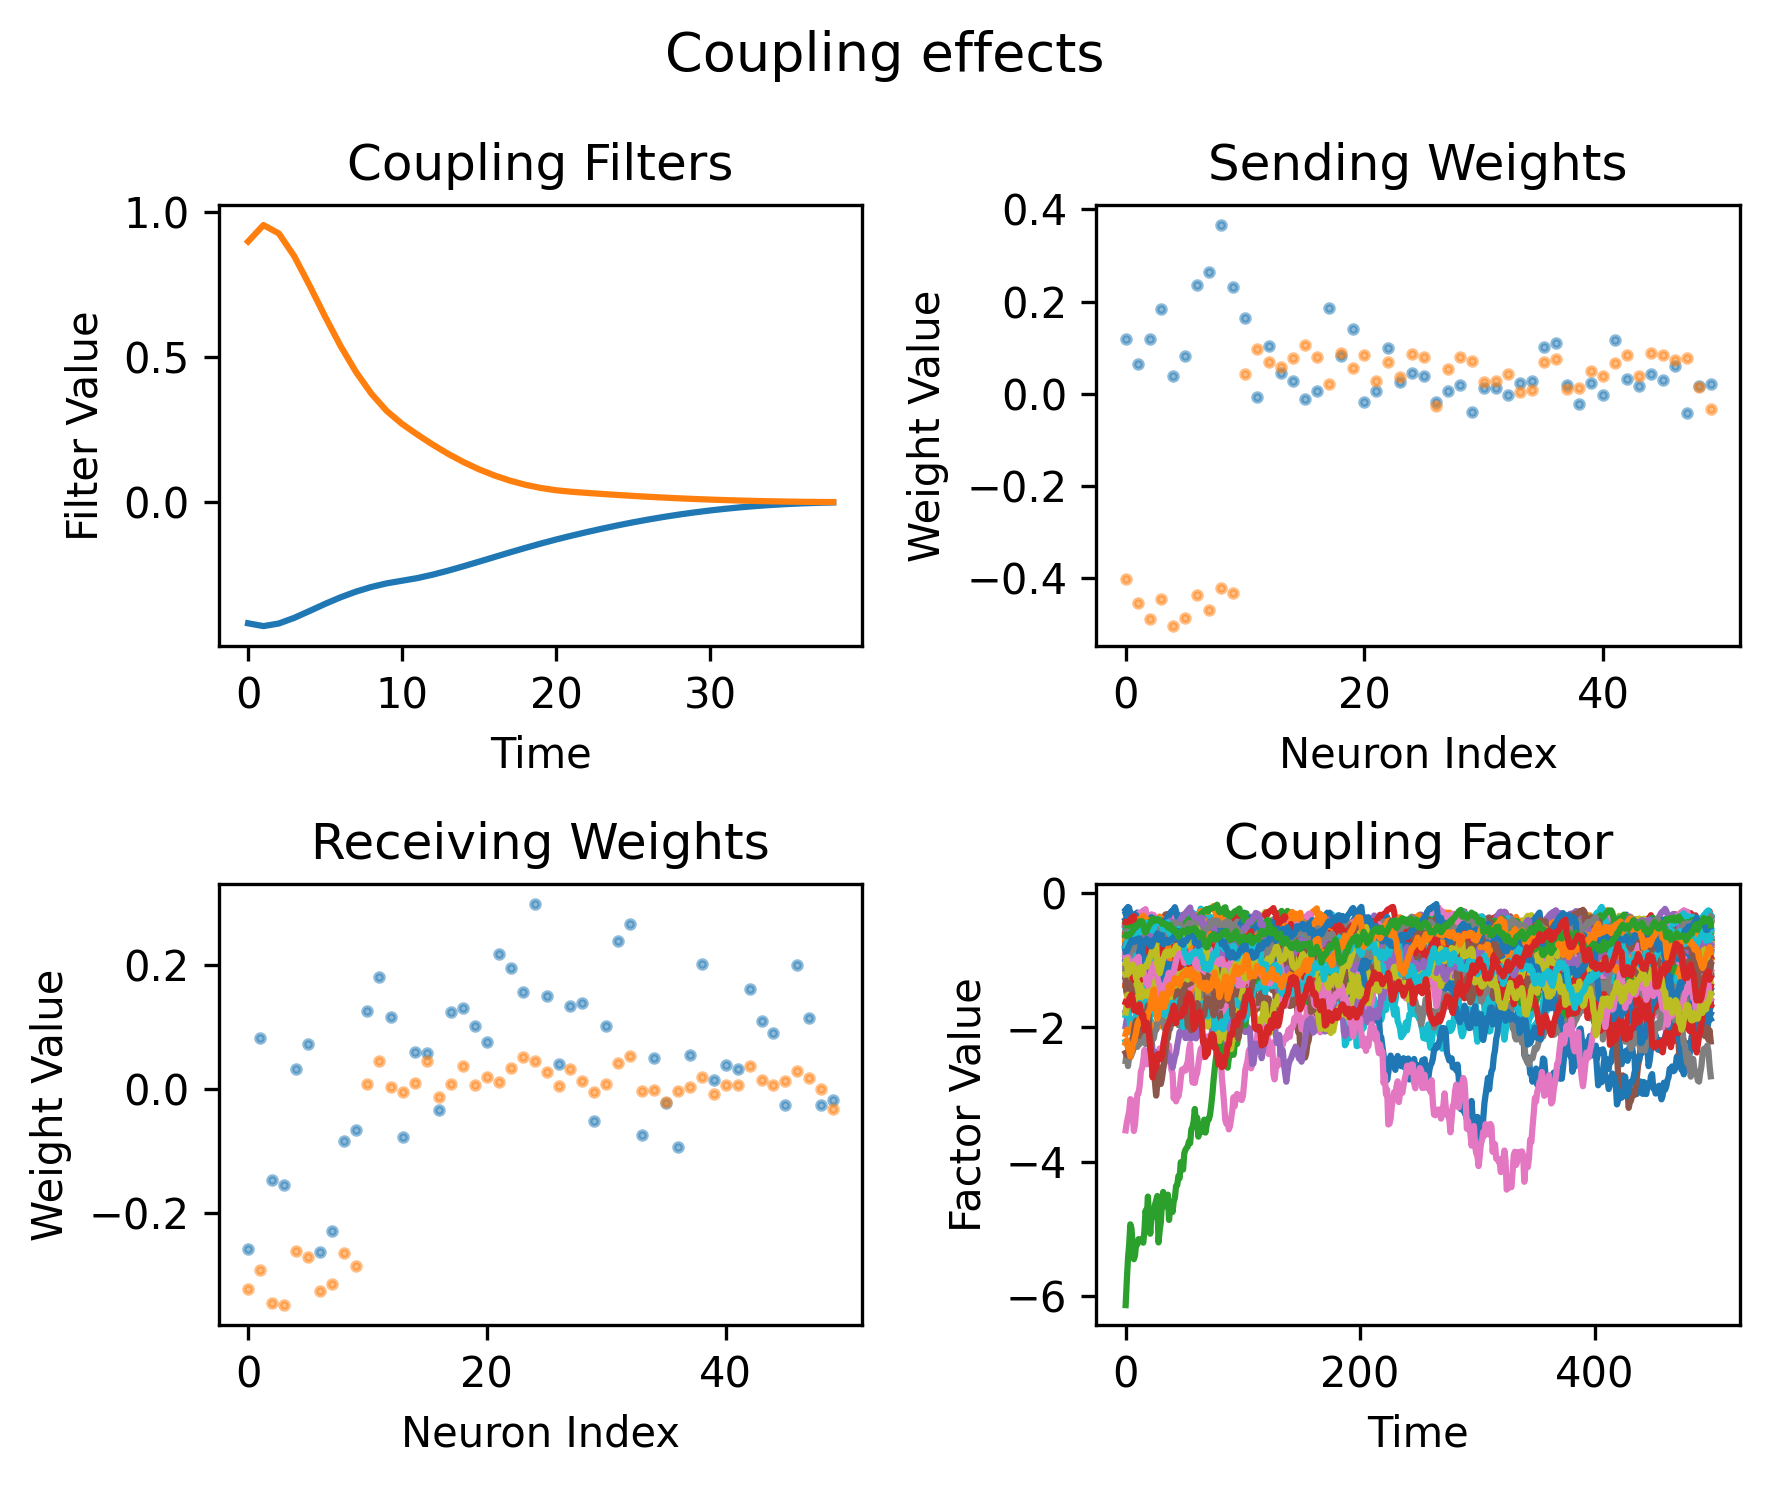

In [234]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Coupling effects', 
    fontsize=13
)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][0][1].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[0][1].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()


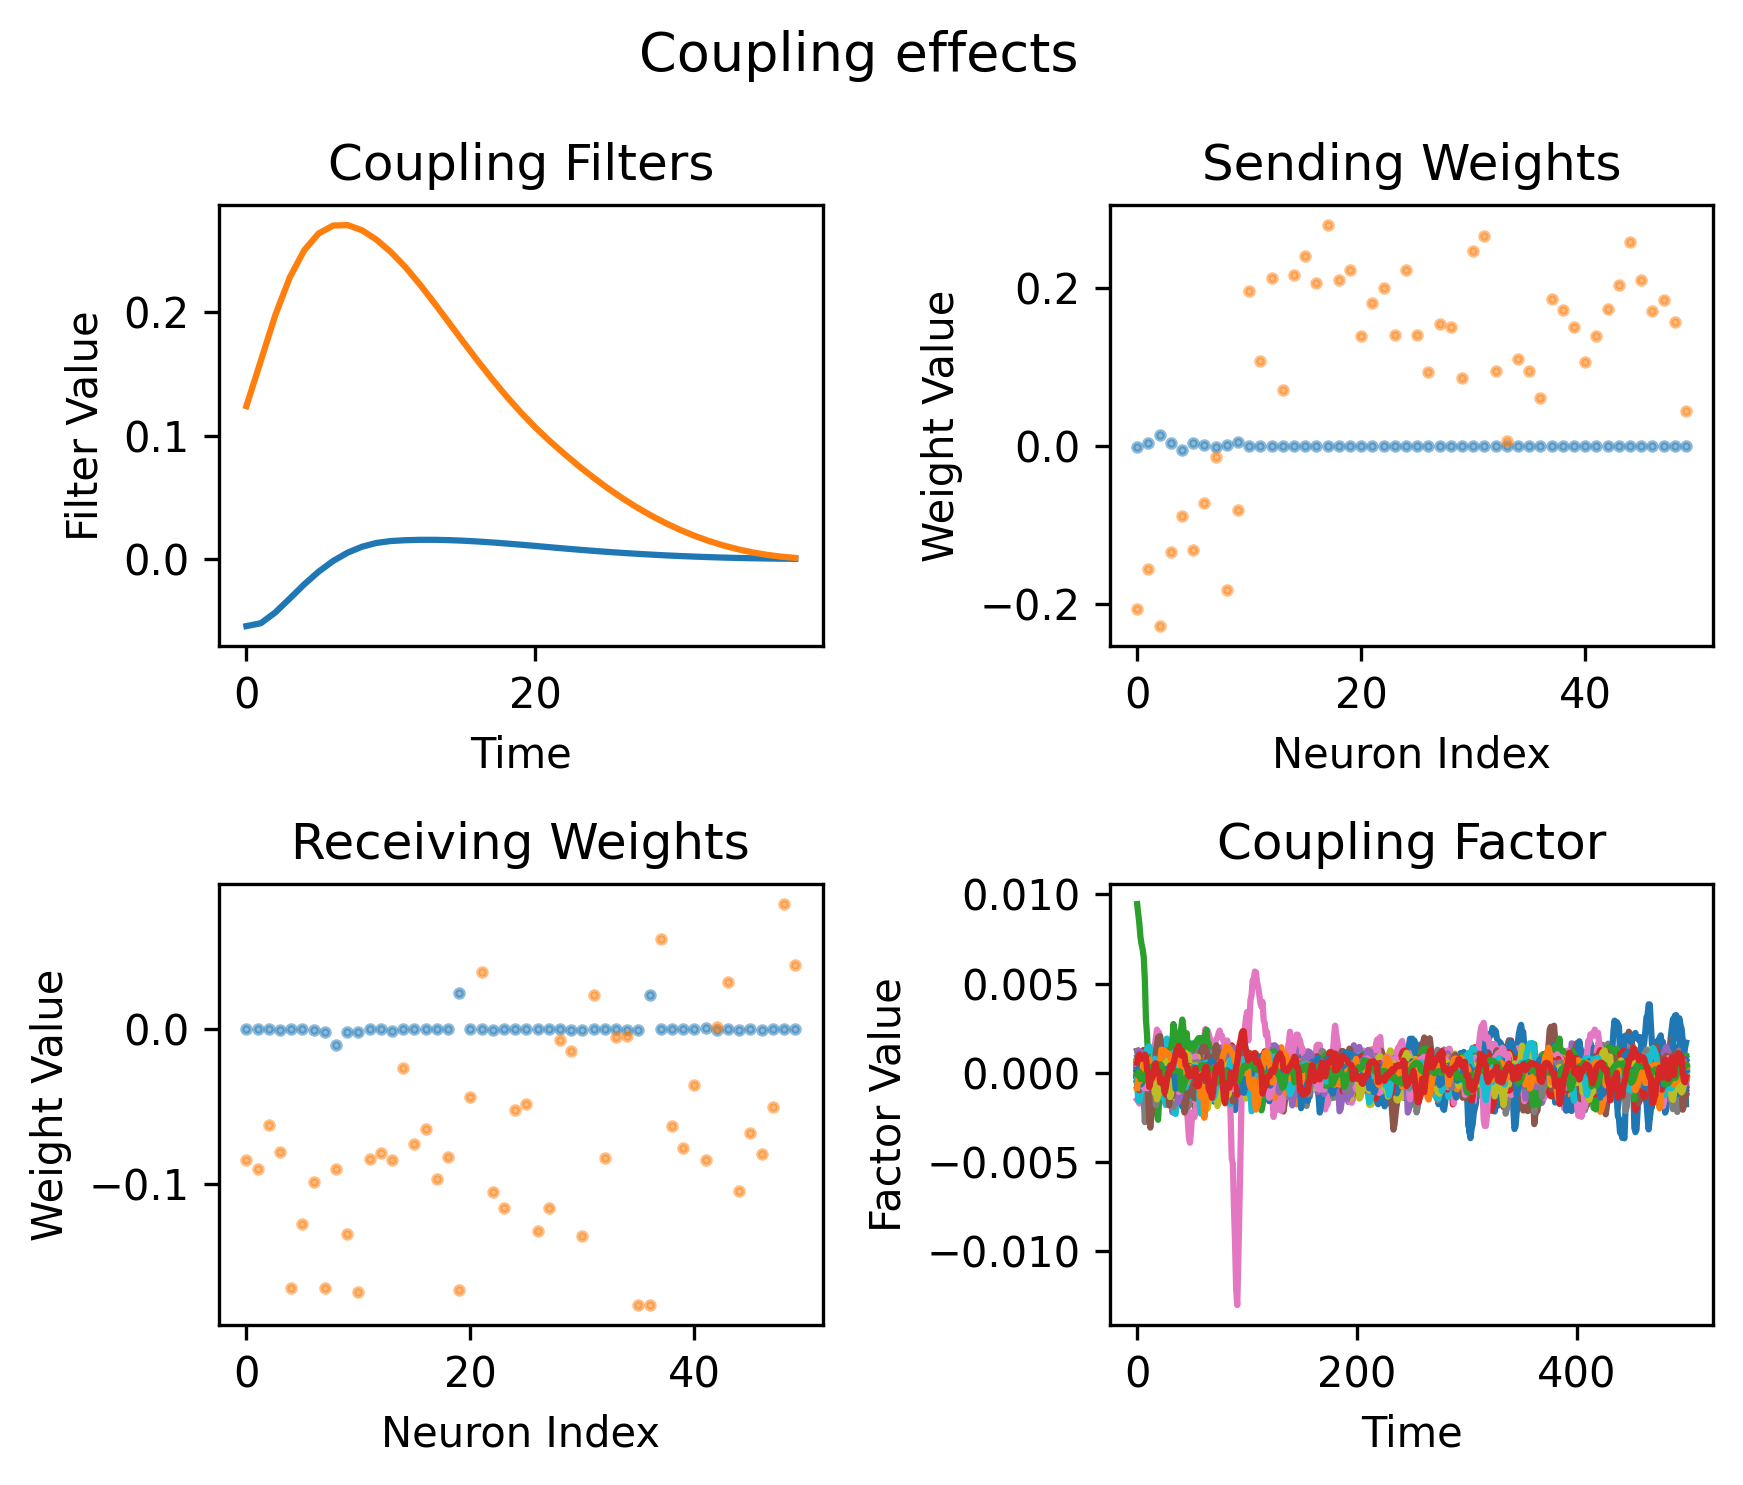

In [235]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Coupling effects', 
    fontsize=13
)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][1][0].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][1][0].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][1][0].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[1][0].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()
